In [1]:
!if [[ ! -d PROJECT ]] && [[ ! -d PIGEON ]]; then git clone https://github.com/iggy2k/CSC490-Project-Winter-2025.git PROJECT; fi

Cloning into 'PROJECT'...
remote: Enumerating objects: 497, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 497 (delta 79), reused 92 (delta 37), pack-reused 352 (from 1)
Receiving objects: 100% (497/497), 34.13 MiB | 19.49 MiB/s, done.
Resolving deltas: 100% (249/249), done.


In [2]:
import os
import sys

# use this path for colab
sys.path.append(os.path.abspath('./PROJECT'))

# use this path for local
# Local
# if os.path.isdir('PIGEON/'):
#     PIGEON_DIR = 'PIGEON/'
# # Git clone when colab
# else:
#     PIGEON_DIR = 'PROJECT/PIGEON/'

# os.environ["PIGEON_DIR"] = PIGEON_DIR
# sys.path.insert(1, PIGEON_DIR)

In [3]:
# Import setup module
from modules.setup import install_dependencies, extract_dataset
from modules.drive import setup_dataset

# Run setup steps
setup_dataset(local_path="./490data.tar.gz")
install_dependencies()
extract_dataset()


📥 Copying dataset from /content/drive/My Drive/490data.tar.gz...
📂 Extracting dataset...


  0%|          | 0/26 [00:00<?, ?it/s]

✅ Successfully installed fiona
✅ Successfully installed folium
✅ Successfully installed geopandas
✅ Successfully installed huggingface_hub
✅ Successfully installed ipython
✅ Successfully installed ipywidgets
✅ Successfully installed jinja2
✅ Successfully installed jupyter
✅ Successfully installed markupsafe
⚠️ Error installing matplotlib-base: Command 'pip install matplotlib-base' returned non-zero exit status 1.
✅ Successfully installed matplotlib-inline
✅ Successfully installed nbconvert
✅ Successfully installed nbformat
✅ Successfully installed notebook
✅ Successfully installed numpy
✅ Successfully installed pandas
✅ Successfully installed pip
✅ Successfully installed pynvml
⚠️ Error installing python: Command 'pip install python' returned non-zero exit status 1.
⚠️ Error installing pytorch: Command 'pip install pytorch' returned non-zero exit status 1.
✅ Successfully installed scikit-learn
✅ Successfully installed scipy
✅ Successfully installed torchvision
✅ Successfully installed 

In [4]:
# This is supposed to make sure if you edit .py files
# colab will pick up on it
%load_ext autoreload
%autoreload 2

In [5]:
from modules.dataset import (
    download_osv5m_dataset,
    extract_zip_files,
    load_datasets,
    create_dataloaders,
    get_device
)

download_osv5m_dataset()
extract_zip_files()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

train.csv:   0%|          | 0.00/2.92G [00:00<?, ?B/s]

00.zip:   0%|          | 0.00/2.52G [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/116M [00:00<?, ?B/s]

00.zip:   0%|          | 0.00/2.25G [00:00<?, ?B/s]

Extracting datasets/osv5m/images/test/00.zip:   0%|          | 0/50001 [00:00<?, ?it/s]

Extracting datasets/osv5m/images/train/00.zip:   0%|          | 0/50001 [00:00<?, ?it/s]

In [6]:
train_dataset, val_dataset = load_datasets(1000)
train_dataloader, val_dataloader = create_dataloaders(train_dataset, val_dataset)

Reading datasets/osv5m/images/train/00
Found 50000 files.


Loading data: 0it [00:00, ?it/s]

Found 4894684 csv entries.


Processing files:   0%|          | 0/50000 [00:00<?, ?it/s]

Keeping 1000 items
Dataset ready, 1000 files.
Skipped 0 non-land files.
Reading datasets/osv5m/images/test/00
Found 50000 files.


Loading data: 0it [00:00, ?it/s]

Found 210122 csv entries.


Processing files:   0%|          | 0/50000 [00:00<?, ?it/s]

Keeping 1000 items
Dataset ready, 1000 files.
Skipped 0 non-land files.
✅ Loaded Train: 1000 images, Validation: 1000 images


In [7]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  print('using cuda')
else:
  device = torch.device("cpu")
  print('using cpu')

using cuda


In [8]:
# !pip install -q git+https://github.com/openai/CLIP.git

In [9]:
!mkdir -p data/geocells/
# Political boundaries (admin0 = country)
![ ! -f data/geocells/admin_2.geojson ] && wget --show-progress -O data/geocells/admin_2.geojson -q https://github.com/wmgeolab/geoBoundaries/raw/main/releaseData/CGAZ/geoBoundariesCGAZ_ADM2.geojson
![ ! -f data/geocells/admin_1.geojson ] && wget --show-progress -O data/geocells/admin_1.geojson -q https://github.com/wmgeolab/geoBoundaries/raw/main/releaseData/CGAZ/geoBoundariesCGAZ_ADM1.geojson
![ ! -f data/geocells/countries.geojson ] && wget --show-progress -O data/geocells/countries.geojson -q https://github.com/wmgeolab/geoBoundaries/raw/main/releaseData/CGAZ/geoBoundariesCGAZ_ADM0.geojson

data/geocells/admin 100%[===================>] 524.95M  80.7MB/s    in 6.8s    
data/geocells/admin 100%[===================>] 343.82M  79.6MB/s    in 4.6s    
data/geocells/count 100%[===================>] 382.61M  86.7MB/s    in 4.7s    


In [10]:
!pip install -q geojson

In [11]:
from modules.geocell import hook, simplify_geojson

Simplifying geojson file for faster geocell gen...


Loading: 100%|██████████| 3224/3224 [00:01<00:00, 1617.97it/s]


data/geocells/admin_1.geojson Size in MegaBytes is 343.82455825805664
Simplified 8817812 polygons to 131494


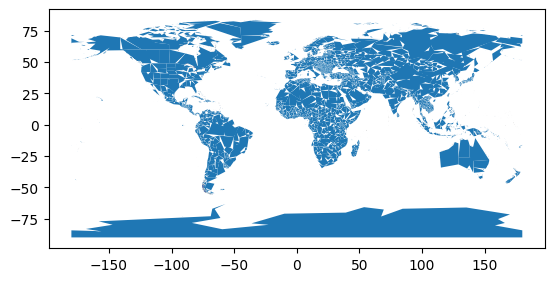

data/geocells/admin_1.geojson_compressed_2.5.geojson Size in MegaBytes is 5.246394157409668


Loading: 100%|██████████| 49349/49349 [00:31<00:00, 1565.83it/s]


data/geocells/admin_2.geojson Size in MegaBytes is 524.9471464157104
Simplified 13153497 polygons to 327604


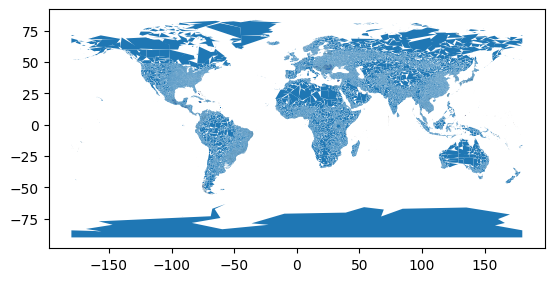

data/geocells/admin_2.geojson_compressed_2.5.geojson Size in MegaBytes is 14.199664115905762


Loading: 100%|██████████| 218/218 [00:00<00:00, 1737.08it/s]


data/geocells/countries.geojson Size in MegaBytes is 382.61291885375977
Simplified 10075273 polygons to 23479


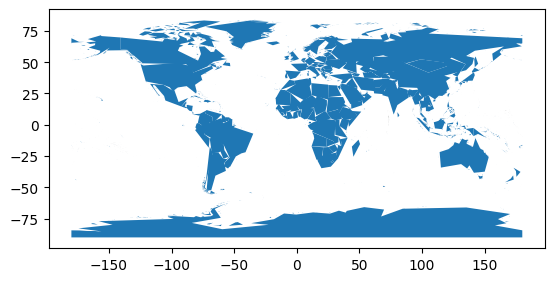

data/geocells/countries.geojson_compressed_2.5.geojson Size in MegaBytes is 0.9441022872924805
New geojson files: data/geocells/countries.geojson_compressed_2.5.geojson data/geocells/admin_1.geojson_compressed_2.5.geojson data/geocells/admin_2.geojson_compressed_2.5.geojson


In [12]:
from pathlib import Path

SIMPLIFY_GEOJSON = True

if SIMPLIFY_GEOJSON:
    print('Simplifying geojson file for faster geocell gen...')

    new_admin1 = simplify_geojson('data/geocells/admin_1.geojson', 2.5)
    new_admin2 = simplify_geojson('data/geocells/admin_2.geojson', 2.5)
    new_countries = simplify_geojson('data/geocells/countries.geojson', 2.5)

    COUNTRY_PATH = 'data/geocells/countries.geojson_compressed_2.5.geojson'
    ADMIN_1_PATH = 'data/geocells/admin_1.geojson_compressed_2.5.geojson'
    ADMIN_2_PATH = 'data/geocells/admin_2.geojson_compressed_2.5.geojson'

    print('New geojson files:', COUNTRY_PATH, ADMIN_1_PATH, ADMIN_2_PATH)

In [13]:
# TODO: pre-generate all this, add to the repo and add option to load instead
import sys

if os.path.isdir('PIGEON/'):
    PIGEON_DIR = 'PIGEON/'
# Git clone when colab
else:
    PIGEON_DIR = 'PROJECT/PIGEON/'

os.environ["PIGEON_DIR"] = PIGEON_DIR
sys.path.insert(1, PIGEON_DIR)

sys.path.append(f'{PIGEON_DIR}/dataset_creation/geocell')
sys.path.append(PIGEON_DIR)

from geocell_creation import *

GEOCELL_PATH = 'data/geocells_yfcc.csv'
df = train_dataset.df
geocells_file = Path(GEOCELL_PATH)
if not geocells_file.is_file():
    geocell_creator = GeocellCreator(df, GEOCELL_PATH)
    geocells = geocell_creator.generate()
else:
  print('Loading existing geocells')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Loading geographic boundaries ...
 ... loaded admin 2 boundaries.
 ... loaded admin 1 boundaries.
 ... loaded countries.


Fusing cells within countries: 100%|██████████| 95/95 [11:01<00:00,  6.97s/country] 


||| NEW OPTICS PARAMS |||  (300, 0.05)
||| NEW OPTICS PARAMS |||  (400, 0.005)
||| NEW OPTICS PARAMS |||  (1000, 0.0001)


In [14]:
!pip install -q huggingface-hub transformers pygeos
!pip install -q -U dill datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.3 MB/s eta 0:00:00


In [15]:
from accelerate import Accelerator
accelerator = Accelerator()

In [17]:
from modules.model import GeoLocationModel

In [18]:
from modules.loss import HaversineLoss

In [19]:
import torch.optim as optim

from torch.optim.lr_scheduler import ExponentialLR

haversineLoss = HaversineLoss()
# mseLoss = nn.MSELoss()
# ceLoss = nn.CrossEntropyLoss()
# model = GeoLocationModel()


In [20]:
!pip install -q livelossplot

In [21]:
from livelossplot import PlotLosses

In [22]:
from ipywidgets import Output
OUTPUT_CONTEXT = Output()
display(OUTPUT_CONTEXT)

Output()

In [63]:
embedder = None
dataset = None
torch.cuda.empty_cache()

In [64]:
# WIP: trying to get the dataset preprocess to work
# in order for refiner to work

dataset_path = DATASET_PATH_YFCC

from models.clip_embedder import *
from dataset_creation.finetune.finetune_dataset import *
from preprocessing.dataset_preprocessing import *

IMAGE_PATH = '/content/datasets/osv5m/images/test/00'
METADATA_PATH = '/content/datasets/osv5m/train.csv_filtered.csv'
embedder = CLIPEmbedding('geolocal/StreetCLIP', load_checkpoint=False, panorama=False)
dataset = generate_finetune_dataset(sample=None, geo_augment=False, metadata_path=METADATA_PATH,
                                            image_path='/content/datasets/osv5m/images/test/00')
from preprocessing.embed import *

# embed_images(embedder, dataset)
# compute_embeddings('train', model, train_data, accelerator)

dataset = preprocess(dataset, geocell_path=GEOCELL_PATH_YFCC, embedder=embedder, multi_task=False)
dataset.save_to_disk(dataset_path)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 10.12 MiB is free. Process 12349 has 14.73 GiB memory in use. Of the allocated memory 14.61 GiB is allocated by PyTorch, and 25.69 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [30]:
from dataset_creation.prototype.prototype import *

data_df = pd.read_csv('data/data_yfcc_augmented_non_contaminated.csv')
data_df = gpd.GeoDataFrame(data_df, geometry=gpd.points_from_xy(data_df.longitude, data_df.latitude), crs='EPSG:4326')
dataset = ProtoDataset(data_df, DATASET_PATH_YFCC, 'data_prototypes_YFCC_100.csv')
dataset.generate()

AttributeError: 'ProtoDataset' object has no attribute 'embeddings'

In [ ]:
proto_path = PROTO_PATH_YFCC if yfcc else PROTO_PATH
dataset_path = DATASET_PATH_YFCC if yfcc else DATASET_PATH
refiner = ProtoRefiner(20, False, 10000, proto_path=proto_path, dataset_path=dataset_path,
                                   temperature=1)

In [ ]:
# Clean-up if re-running
model = GeoLocationModel(refiner=refiner)

optimizer = optim.SGD(model.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.8)
torch.cuda.empty_cache()

In [ ]:
from modules.train import train_model
from accelerate import Accelerator

# Initialize necessary components
accelerator = Accelerator()

# Call the function
avg_epoch_loss = train_model(
    model=model,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    accelerator=accelerator,
    scheduler=scheduler,
    num_epochs=1,
    haversineLoss=haversineLoss,
    OUTPUT_CONTEXT=OUTPUT_CONTEXT
)

In [ ]:
import matplotlib.pyplot as plt
avg_epoch_loss = torch.tensor(avg_epoch_loss, device =  'cpu')
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(avg_epoch_loss) + 1), avg_epoch_loss, label='Loss', color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
model.eval()

In [ ]:
avg_val_haversine_loss = 0.0
batch_haversine = []

model, optimizer, val_dataloader = accelerator.prepare(model, optimizer, val_dataloader)

with torch.no_grad():  # Disable gradient calculation for validation
    for images, coordinates, image_path in tqdm(val_dataloader, total=len(val_dataloader), desc=f'Validating'):
        # Forward pass
        images, coordinates = images.cuda(), coordinates.cuda()
        outputs = model(images, coordinates, image_path)
        loss_haversine = haversineLoss(outputs['pred'], coordinates).mean(dim=-1)
        batch_haversine.append(loss_haversine)
        avg_val_haversine_loss += loss_haversine

# Calculate average loss and haversine
avg_val_haversine_loss /= len(val_dataloader)

print(f'Validation Haversine Loss: {avg_val_haversine_loss:.4f}')

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

# Back from gpu
batch_haversine = torch.tensor(batch_haversine, device =  'cpu')

# Remove outliers
batch_haversine = median_filter(batch_haversine, size=100)

plt.figure(figsize=(5, 5))
plt.subplot(1, 1, 1)
plt.plot(range(1, len(batch_haversine) + 1), batch_haversine, label='Validation haversine', color='green', marker='o')
plt.xlabel('Batch Number')
plt.ylabel('haversine')
plt.title('Validation haversine loss per Batch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from modules.plot import plot_predictions

In [ ]:
plot_predictions(model, val_dataloader, num_samples=10)